# Homework 3

In this assignment, we'll explore some of the geometry that underlies how camera images are formed.

**SUBMISSION NOTE**: 

1. Make sure that the first line in any Python cell with a function is the `def` line. The HW submission script will fail to detect the function unless the function definition is on the first line of the code cell in the Python Notebook.

2. Make sure the file name of the Python file you upload to Gradescope is named `hw3.py`. This is required for the autograder to run correctly.

In [ ]:
import os

if not os.path.exists("cs131"):
    # Clone the repository if it doesn't already exist
    !git clone https://github.com/StanfordVL/CS131_release.git

%cd CS131_release/winter_2025/hw3_release/

In [1]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from typing import Tuple

def hash_numpy(x):
    import hashlib

    return hashlib.sha1(x.view(np.uint8)).hexdigest()


%load_ext autoreload
%autoreload 2

## 1. Transformations in 3D

In order to make sense of how objects in our world are rendered in a camera, we typically need to understand how they are located relative to the camera. In this question, we'll examine some properties of the transformations that formalize this process by expressing coordinates with respect to multiple frames.

We'll be considering a scene with two frames: a world frame ($W$) and a camera frame ($C$).

Notice that:
- We have 3D points $p$, $q$, $r$, and $s$ that define a square, which is parallel to the world $zy$ plane
- $C_z$ and $C_x$ belong to the plane defined by $W_z$ and $W_x$
- $C_y$ is parallel to $W_y$

<!-- into camera space as we translate a simple shape from world coordinates to camera coordinates. We will take this square in world coordinates and transform it into the camera coordinates.-->

### 1.1 Reference Frame Definitions

First, we'll take a moment to validate your understanding of 3D reference frames.

Consider creating:
- A point $w$ at the origin of the world frame ($O_w$)
- A point $c$ at the origin of the camera frame ($O_c$)

Examine the $x$, $y$, and $z$ axes of each frame, then express these points with respect to the world and camera frames. Fill in **`w_wrt_camera`**, **`w_wrt_world`**, and **`c_wrt_camera`**.

You can consider the length $d = 1$.

In [4]:
d = 1.0

# Abbreviation note:
# - "wrt" stands for "with respect to", which is ~synonymous with "relative to"

w_wrt_world = np.array([0.0, 0.0, 0.0])  # Done for you
w_wrt_camera = None  # Assign me below!

c_wrt_world = None  # Assign me below!
c_wrt_camera = None  # Assign me below!

### YOUR CODE HERE: Assign values to w_wrt_camera, w_wrt_world, and c_wrt_camera below.
w_wrt_camera = np.array([0.0, 0.0, 1.0])  # Assign me below!

c_wrt_world = np.array([1.0 / np.sqrt(2), 0.0, 1.0 / np.sqrt(2)])  # Assign me below!
c_wrt_camera = np.array([0.0, 0.0, 0.0])  # Assign me below!
### END YOUR CODE

In [5]:
# Run this cell to check your answers!
assert (
    (3,)
    == w_wrt_world.shape
    == w_wrt_camera.shape
    == c_wrt_world.shape
    == c_wrt_camera.shape
), "Wrong shape!"
assert (
    hash_numpy(w_wrt_world) == "d3399b7262fb56cb9ed053d68db9291c410839c4"
), "Double check your w_wrt_world!"
assert (
    hash_numpy(w_wrt_camera) == "6248a1dcfe0c8822ba52527f68f7f98955584277"
), "Double check your w_wrt_camera!"
assert (
    hash_numpy(c_wrt_camera) == "d3399b7262fb56cb9ed053d68db9291c410839c4"
), "Double check your c_wrt_camera!"
assert (
    hash_numpy(c_wrt_world) == "a4c525cd853a072d96cade8b989a9eaf1e13ed3d"
), "Double check your c_wrt_world!"

print("Looks correct!")

Looks correct!


### 1.2 World ⇨ Camera Transforms

Derive the homogeneous transformation matrix needed to convert a point expressed with respect to the world frame $W$ in the camera frame $C$.

**Discuss the rotation and translation terms in this matrix and how you determined them, then implement it in `camera_from_world_transform()`**.

We've also supplied a set of `assert` statements below to help you check your work.

---

*Hint #1:*
With rotation matrix $R \in \mathbb{R}^{3\times 3}$ and translation vector $t \in \mathbb{R}^{3\times 1}$, you can write transformations as $4 \times 4$ matrices:
$$
\begin{bmatrix}{x_C} \\ {y_C} \\ {z_C} \\ 1\end{bmatrix} =
\begin{bmatrix}
    R & t \\
    \vec{0}^\top & 1
\end{bmatrix}
\begin{bmatrix}{x_W} \\ {y_W} \\ {z_W} \\ 1\end{bmatrix}
$$

*Hint #2: Remember our 2D transformation matrix for rotations in the $xy$ plane.*

$$\begin{bmatrix}{x}' \\ {y}'\end{bmatrix} = \begin{bmatrix} \cos(\theta) & -\sin(\theta) \\ \sin(\theta) & \cos(\theta)\end{bmatrix} \begin{bmatrix}{x} \\ {y}\end{bmatrix}$$

To apply this to 3D rotations, you might think of this $xy$ plane rotation as holding the $z$ coordinate constant, since that's the axis you're rotating around, and transforming the $x$ and $y$ coordinates as described in the 2D formulation:

$$\begin{bmatrix}{x}' \\ {y}' \\ {z}'\end{bmatrix}  = \begin{bmatrix} \cos(\theta) & -\sin(\theta) & 0 \\ \sin(\theta) & \cos(\theta) & 0 \\ 0 & 0 & 1\end{bmatrix} \begin{bmatrix}{x} \\ {y} \\ {z}\end{bmatrix}$$

(Alternatively you could simply take the rotation matrix from the [Wikipedia](https://en.wikipedia.org/wiki/Rotation_matrix) page)

*Hint #3: In a homogeneous transform, the translation is applied after the rotation.*

As a result, you can visualize the translation as an offset in the output frame.

The order matters! You'll end up with a different transformation if you translate and then rotate versus if you rotate first and then translate with the same offsets. In lecture 2 we discussed a formulation for a combinated scaling, rotating, and translating matrix (in that order), which can be a useful starting point.

---

**Your responses here:**

Notice it is a **135° rotation about the Y-axis**:

\begin{equation*}
    R =
    \begin{bmatrix}
        \cos(135^\circ) & 0 & \sin(135^\circ) \\
        0 & 1 & 0 \\
        -\sin(135^\circ) & 0 & \cos(135^\circ)
    \end{bmatrix}
    =
    \begin{bmatrix}
        -\frac{\sqrt{2}}{2} & 0 & \frac{\sqrt{2}}{2} \\
        0 & 1 & 0 \\
        -\frac{\sqrt{2}}{2} & 0 & -\frac{\sqrt{2}}{2}
    \end{bmatrix}
\end{equation*}

The camera is positioned at:

\begin{equation*}
    t = -R \begin{bmatrix} d/\sqrt{2} \\ 0 \\ d/\sqrt{2} \end{bmatrix} = \begin{bmatrix} 0 \\ 0 \\ -d \end{bmatrix}
\end{equation*}

Therefore,
\begin{equation*}
    T =
    \begin{bmatrix}
        -\frac{\sqrt{2}}{2} & 0 & \frac{\sqrt{2}}{2} & 0 \\
        0 & 1 & 0 & 0 \\
        -\frac{\sqrt{2}}{2} & 0 & -\frac{\sqrt{2}}{2} & -d \\
        0 & 0 & 0 & 1
    \end{bmatrix}
\end{equation*}


In [6]:
def camera_from_world_transform(d: float = 1.0) -> np.ndarray:
    """Define a transformation matrix in homogeneous coordinates that
    transforms coordinates from world space to camera space, according
    to the coordinate systems in Question 1.


    Args:
        d (float, optional): Total distance of displacement between world and camera
            origins. Will always be greater than or equal to zero. Defaults to 1.0.

    Returns:
        T (np.ndarray): Left-hand transformation matrix, such that c = Tw
            for world coordinate w and camera coordinate c as column vectors.
            Shape = (4,4) where 4 means 3D+1 for homogeneous.
    """
    T = np.eye(4)

    # YOUR CODE HERE
    theta = 3 * np.pi / 4 
    R = np.array([
        [np.cos(theta), 0, np.sin(theta)],
        [0,             1, 0            ],
        [-np.sin(theta), 0, np.cos(theta)]
    ])

    c_w = np.array([d / np.sqrt(2), 0, d / np.sqrt(2)])
    t = -R @ c_w

    T[:3, :3] = R
    T[:3, 3] = t
    # END YOUR CODE

    assert T.shape == (4, 4)
    return T

Here, we will check the outputs of your function against the reference frames from Part 1.1!

In [7]:
# Check your answer against 1.1!
T_camera_from_world = camera_from_world_transform()

# Check c_wrt_camera against T_camera_from_world @ w_wrt_world
w_wrt_camera_computed = (T_camera_from_world @ np.append(w_wrt_world, 1.0))[:3]
print(f"w_wrt camera: expected {w_wrt_camera}, computed {w_wrt_camera_computed}")

assert np.allclose(
    w_wrt_camera, w_wrt_camera_computed
), "Error! (likely bad translation)"
print("Translation components look reasonable!")

# Check w_wrt_camera against T_camera_from_world @ c_wrt_world
c_wrt_camera_computed = (T_camera_from_world @ np.append(c_wrt_world, 1.0))[:3]
print(f"c_wrt camera: expected {c_wrt_camera}, computed {c_wrt_camera_computed}")
assert np.allclose(
    c_wrt_camera, c_wrt_camera_computed
), "Error! (likely bad rotation)"
print("Rotation components looks reasonable!")

w_wrt camera: expected [0. 0. 1.], computed [-1.11022302e-16  0.00000000e+00  1.00000000e+00]
Translation components look reasonable!
c_wrt camera: expected [0. 0. 0.], computed [0. 0. 0.]
Rotation components looks reasonable!


### 1.3 Preserving Edge Orientations (Geometric Intuition)

**Under the translation and rotation transformation from world coordinates to camera coordinates, which, if any, of the edges of the square retain their orientation and why?**

**For those that change orientation, how do they change?** (e.g. translation x,y,z and rotation in one of our planes).

A sentence or two of geometric intuition is sufficient for each question, such as reasoning about the orientation of the edges and which axes we're rotating and translating about.

---

**Your response here:** Write your answer in this markdown cell.

Since the translation is esentially rotating around the Y-axis. The edge parallel to Y-axis will still parallel to Y-axis. The edge parallel to X or Z-axis will rotate and now have components in both the X and Z directions. 


### 1.4 Preserving Edge Orientations (Mathematical Proof)

We'll now connect this geometric intuition to your transformation matrix. Framing transformations as matrix multiplication is useful because it allows us to rewrite the difference between two transformed points as the transformation of the difference between the original points. For example, take points $a$ and $b$ and a transformation matrix $T$: $Ta - Tb = T(a-b)$.

All of the edges in the $p,q,r,s$ square are axis-aligned, which means each edge has a nonzero component on only one axis. Assume that the square is 1 by 1, and apply your transformation to the edge vectors $bottom=q-p$ and $left=s-p$ to show which of these edges rotate and how.

*Notation:*
You can apply the transformation to vectors representing the direction of each edge. If we transform all 4 corners, then the vector representing the direction of the transformed square's bottom is:
$$\begin{bmatrix}{bottom_x}' \\ {bottom_y}' \\ {bottom_z}' \\ 0\end{bmatrix} = T\begin{bmatrix}{q_x} \\ {q_y} \\ {q_z} \\ 1\end{bmatrix} -T\begin{bmatrix}{p_x} \\ {p_y} \\ {p_z} \\ 1\end{bmatrix}$$

Using matrix rules, we can rewrite this in terms of the edges of the original square
$$\begin{bmatrix}{bottom_x}' \\ {bottom_y}' \\ {bottom_z}' \\ 0\end{bmatrix} = T\begin{bmatrix}{q_x}-p_x \\ {q_y}-p_y \\ {q_z}-p_z \\ 0\end{bmatrix}$$

**Eliminate the $q - p$ components that you know to be 0, and then apply your transformation to obtain the vector $bottom' = q' - p'$ defined above. Do the same for $left' = s' -p'$. Which edge rotated, and which one didn't?**

---

**Your response here:**

Given the transformation matrix $ T $, the transformed edge vectors are:

$$
\begin{bmatrix}
    {bottom_x}' \\ {bottom_y}' \\ {bottom_z}' \\ 0
\end{bmatrix}
=
T
\begin{bmatrix}
    q_x - p_x \\ q_y - p_y \\ q_z - p_z \\ 0
\end{bmatrix}
= T
\begin{bmatrix} 1 \\ 0 \\ 0 \\ 0 \end{bmatrix}
=
\begin{bmatrix}
    -\frac{\sqrt{2}}{2} \\
    0 \\
    -\frac{\sqrt{2}}{2} \\
    0
\end{bmatrix}
$$

$$
\begin{bmatrix}
    {left_x}' \\ {left_y}' \\ {left_z}' \\ 0
\end{bmatrix}
=
T
\begin{bmatrix}
    s_x - p_x \\ s_y - p_y \\ s_z - p_z \\ 0
\end{bmatrix}
=T
\begin{bmatrix} 0 \\ 1 \\ 0 \\ 0 \end{bmatrix}
=
\begin{bmatrix}
    0 \\
    1 \\
    0 \\
    0
\end{bmatrix}
$$

Therefore, 
- **Bottom edge rotates** → It is no longer purely in the X-direction.
- **Left edge remains unchanged** → Still aligned with Y.


*Interesting note:*  This may remind you of eigenvectors: one of these edges (the one that doesn't rotate) is an eigenvector of our transformation matrix!

### 1.5 Visualization

Implement **`apply_transform()`** to help us apply a homogeneous transformation to a batch of points.

Then, run the cell below to start visualizing our frames and the world square in PyPlot!

Using your code, we can animate a GIF that shows the transition of the square from its position in world coordinates to a new position in camera coordinates. We transform the perspective continuously from the world coordinate system to the camera coordinate system. Analogous to a homogeneous transform, you can see that we first rotate to match the orientation of the camera coordinate system, then translate to match the position of the camera origin.

If you want to see how the animation was computed or if you want to play around with its configuration, then check out **`animate_transformation`** in **`utils.py`**!

In [8]:
def apply_transform(T: np.ndarray, points: np.ndarray) -> Tuple[np.ndarray]:
    """Apply a transformation matrix to a set of points.

    Hint: You'll want to first convert all of the points to homogeneous coordinates.
    Each point in the (3,N) shape edges is a length 3 vector for x, y, and z, so
    appending a 1 after z to each point will make this homogeneous coordinates.

    You shouldn't need any loops for this function.

    Args:
        T (np.ndarray):
            Left-hand transformation matrix, such that c = Tw
                for world coordinate w and camera coordinate c as column vectors.
            Shape = (4,4) where 4 means 3D+1 for homogeneous.
        points (np.ndarray):
            Shape = (3,N) where 3 means 3D and N is the number of points to transform.

    Returns:
        points_transformed (np.ndarray):
            Transformed points.
            Shape = (3,N) where 3 means 3D and N is the number of points.
    """
    N = points.shape[1]
    assert points.shape == (3, N)

    # You'll replace this!
    points_transformed = np.zeros((3, N))

    # YOUR CODE HERE
    points_homogeneous = np.vstack((points, np.ones((1, N))))  # Shape (4, N)
    points_transformed_homogeneous = T @ points_homogeneous  # Shape (4, N)
    points_transformed = points_transformed_homogeneous[:3, :]
    # END YOUR CODE

    assert points_transformed.shape == (3, N)
    return points_transformed


...................................................................................

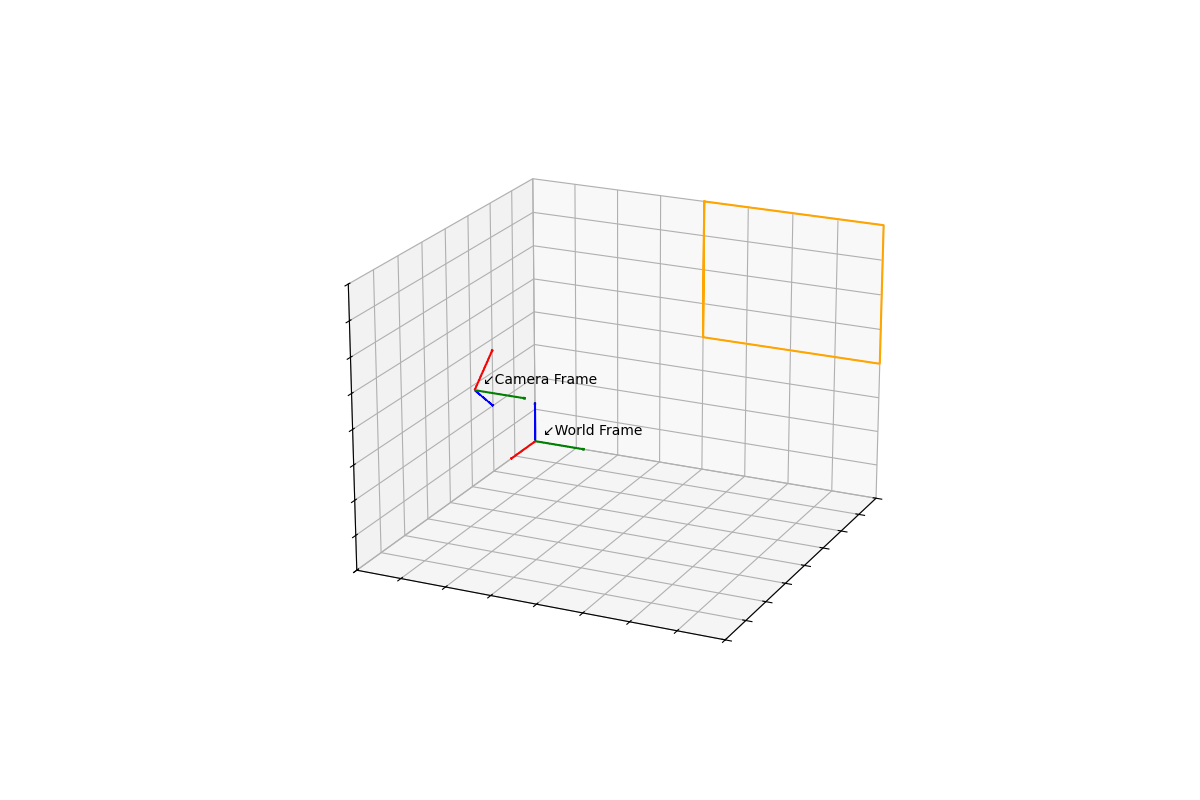

In [9]:
from utils import (
    animate_transformation,
    configure_ax,
    plot_frame,
    plot_square,
)

# Vertices per side of the square
N = 2

# Compute vertices corresponding to each side of the square
vertices_wrt_world = np.concatenate(
    [
        np.vstack([np.zeros(N), np.linspace(1, 2, N), np.ones(N)]),
        np.vstack([np.zeros(N), np.ones(N) + 1, np.linspace(1, 2, N)]),
        np.vstack([np.zeros(N), np.linspace(2, 1, N), np.ones(N) + 1]),
        np.vstack([np.zeros(N), np.ones(N), np.linspace(1, 2, N)]),
    ],
    axis=1,
)

# Visualize our rotation!
animate_transformation(
    "transformation.gif",
    vertices_wrt_world,
    camera_from_world_transform,
    apply_transform,
)

import IPython.display

with open("transformation.gif", "rb") as file:
    display(IPython.display.Image(file.read()))

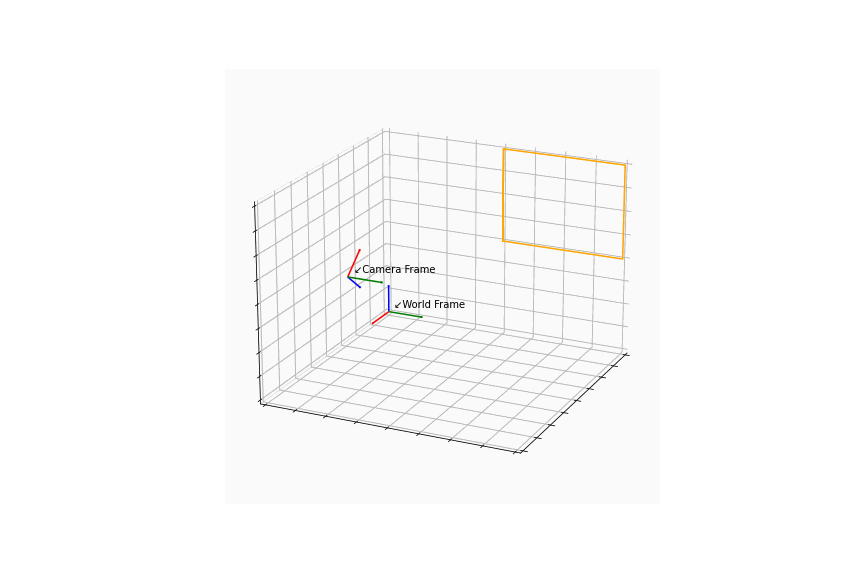

In [10]:
# Compare to staff animation
with open("solution_transformation.gif", "rb") as file:
    display(IPython.display.Image(file.read()))

## 2. Camera Intrinsics & Vanishing Points

In a pinhole camera, lines that are parallel in 3D rarely remain parallel when projected to the image plane. Instead, parallel lines will meet at a **vanishing point**:

### 2.1 Homogeneous coordinates (5 points)

**Consider a line that is parallel to a world-space direction vector in the set $\{ d \in \mathbb{R}^3 : d^\top d = 1\}$. Show that the image coordinates $v$ of the vanishing point can be be written as $v = KRd$.**

*Hints:*
- As per the lecture slides, $K$ is the camera calibration matrix and $R$ is the camera extrinsic rotation.
- As in the diagram above, the further a point on a 3D line is from the camera origin, the closer its projection will be to the line's 2D vanishing point.
- Given a line with direction vector $d$, you can write a point that's infinitely far away from the camera via a limit: $\lim_{\alpha \to \infty} \alpha d$.
- The 3D homogeneous coordinate definition is:
$$
\begin{bmatrix}
    x & y & z & w
\end{bmatrix}^\top
\iff
\begin{bmatrix}
    x/w & y/w & z/w & 1
\end{bmatrix}^\top
$$

**You answer here:** Write your answer in this markdown cell.

A point along a line with direction $ d $ is parameterized as:

\begin{equation*}
    P(\alpha) = \alpha d, \quad \text{as } \alpha \to \infty
\end{equation*}
Using the extrinsic transformation:

\begin{equation*}
    P_C = R P_W + t = R (\alpha d) + t
\end{equation*}
Since translation $ t $ is negligible at infinity, we get:

\begin{equation*}
    P_C = \alpha R d
\end{equation*}
Using the camera projection equation:

\begin{equation*}
    P_{\text{image}} = K P_C = K (\alpha R d)
\end{equation*}
After homogeneous normalization:

\begin{equation*}
    v = \lim_{\alpha \to \infty} \frac{K (\alpha R d)}{\alpha} = K R d
\end{equation*}

### 2.2 Calibration from vanishing points (5 points)

Let $d_0, d_1, \dots$ represent directional vectors for 3D lines in a scene, and $v_0, v_1, \dots$ represent their corresponding vanishing points.

**Consider the situtation when these lines are orthogonal:**
$$
d_i^\top d_j = 0, \text{for each } i \neq j
$$

**Show that:**
$$
(K^{-1}v_i)^\top(K^{-1}v_j) = 0, \text{for each } i \neq j
$$

**You answer here:** 

From the previous result:

\begin{equation*}
    v_i = K R d_i, \quad v_j = K R d_j
\end{equation*}

Applying $ K^{-1} $:

\begin{equation*}
    K^{-1} v_i = R d_i, \quad K^{-1} v_j = R d_j
\end{equation*}

\begin{equation*}
    (K^{-1} v_i)^\top (K^{-1} v_j) = (R d_i)^\top (R d_j)
\end{equation*}

Since rotation preserves dot products:

\begin{equation*}
    (R d_i)^\top (R d_j) = d_i^\top d_j = 0
\end{equation*}



### 2.3 Short Response (5 points)

**Respond to the following using bullet points:**

- In the section above, we eliminated the extrinsic rotation matrix $R$. Why might this simplify camera calibration?

- Assuming square pixels and no skew, how many vanishing points with mutually orthogonal directions do we now need to solve for our camera's focal length and optical center?

- Assuming square pixels and no skew, how many vanishing points with mutually orthogonal directions do we now need to solve for our camera's focal length when the optical center is known?

---

**You answer here:** 

- **Why does eliminating $ R $ simplify camera calibration?**
  - It isolates the intrinsic matrix $ K $, removing dependence on camera orientation.
  - Calibration only requires vanishing points without needing external pose estimation.

- **How many vanishing points are needed to solve for focal length and optical center?**
  - **Two** mutually orthogonal vanishing points.
  - Each vanishing point provides a constraint on $ K $, allowing estimation of both $ f $ and $ (c_x, c_y) $.

- **How many vanishing points are needed to solve for focal length if the optical center is known?**
  - **One** mutually orthogonal vanishing point.
  - Since $ (c_x, c_y) $ is known, the constraint from one vanishing point suffices to solve for $ f $.


## 3. Intrinsic Calibration

Using the vanishing point math from above, we can solve for a camera matrix $K$!

First, let's load in an image. To make life easier for you, we've hand labeled a set of coordinates on it that we'll use to compute vanishing points.

Image is 1300 x 975


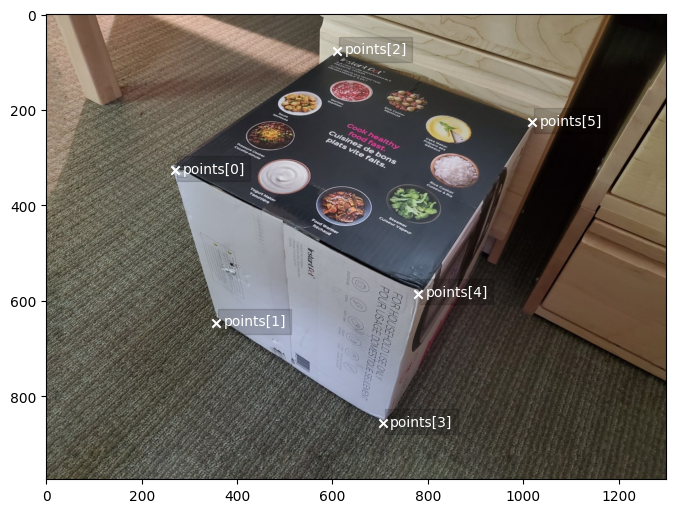

In [11]:
# Load image and annotated points; note that:
# > Our image is a PIL image type; you can convert this to NumPy with `np.asarray(img)`
# > Points are in (x, y) format, which corresponds to (col, row)!
img = Image.open("images/pressure_cooker.jpg")
print(f"Image is {img.width} x {img.height}")
points = np.array(
    [
        [270.0, 327.0],  # [0]
        [356.0, 647.0],  # [1]
        [610.0, 76.0],  # [2]
        [706.0, 857.0],  # [3]
        [780.0, 585.0],  # [4]
        [1019.0, 226.0],  # [5]
    ]
)

# Visualize image & annotated points
fig, ax = plt.subplots(figsize=(8, 10))
ax.imshow(img)
ax.scatter(points[:, 0], points[:, 1], color="white", marker="x")
for i in range(len(points)):
    ax.annotate(
        f"points[{i}]",
        points[i] + np.array([15.0, 5.0]),
        color="white",
        backgroundcolor=(0, 0, 0, 0.15),
        zorder=0.1,
    )

### 3.1 Finding Vanishing Points

In 2D, notice that a vanishing point can be computing by finding the intersection of two lines that we know are parallel in 3D.

To find the vanishing points in the image, implement **`intersection_from_lines()`**.

Then, run the cell below to check that it's working.

Note that later parts of this homework will fail if you choose the side face instead of the front face for producing the leftmost vanishing point.

In [14]:
def intersection_from_lines(
    a_0: np.ndarray, a_1: np.ndarray, b_0: np.ndarray, b_1: np.ndarray
) -> np.ndarray:
    """Find the intersection of two lines (infinite length), each defined by a
    pair of points.

    Args:
        a_0 (np.ndarray): First point of first line; shape `(2,)`.
        a_1 (np.ndarray): Second point of first line; shape `(2,)`.
        b_0 (np.ndarray): First point of second line; shape `(2,)`.
        b_1 (np.ndarray): Second point of second line; shape `(2,)`.

    Returns:
        np.ndarray:
    """
    # Validate inputs
    assert a_0.shape == a_1.shape == b_0.shape == b_1.shape == (2,)
    assert a_0.dtype == a_1.dtype == b_0.dtype == b_1.dtype == float

    # Intersection point between lines
    out = np.zeros(2)

    # YOUR CODE HERE
    a0 = np.append(a_0, 1)
    a1 = np.append(a_1, 1)
    b0 = np.append(b_0, 1)
    b1 = np.append(b_1, 1)

    la = np.cross(a0, a1)
    lb = np.cross(b0, b1)

    intersection_homogeneous = np.cross(la, lb)
    out = intersection_homogeneous[:2] / intersection_homogeneous[2]
    # END YOUR CODE

    assert out.shape == (2,)
    assert out.dtype == float

    return out


In [15]:
# Python trivia: the following two assert statements are the same.
# > https://docs.python.org/3/tutorial/controlflow.html#unpacking-argument-lists
# > https://numpy.org/doc/stable/reference/arrays.indexing.html#integer-array-indexing
assert np.allclose(
    intersection_from_lines(points[0], points[1], points[4], points[0],),
    points[0],
)
assert np.allclose(intersection_from_lines(*points[[0, 1, 4, 0]]), points[0])
print("Looks correct!")

Looks correct!


To use the constraint we derived above, we need to find vanishing points that correspond to three orthogonal direction vectors.

Populate `v0_indices`, `v1_indices`, and `v2_indices`, then run the cell below to compute `v`.

You should be able to get an output that looks like this (color ordering does not matter):

In [36]:
# Select points used to compute each vanishing point
#
# Each `v*_indices` list should contain four integers, corresponding to
# indices into the `points` array; the first two ints define one line and
# the second two define another line.
v0_indices = None
v1_indices = None
v2_indices = None

### YOUR CODE HERE: Instantiate v*_indices!
v0_indices = [0, 2, 4, 5]
v1_indices = [0, 1, 4, 3]
v2_indices = [0, 4, 2, 5]
### END YOUR CODE

# Validate indices
assert (
    len(v0_indices) == len(v1_indices) == len(v2_indices) == 4
), "Invalid length!"
for i, j, k in zip(v0_indices, v1_indices, v2_indices):
    assert type(i) == type(j) == type(k) == int, "Invalid type!"

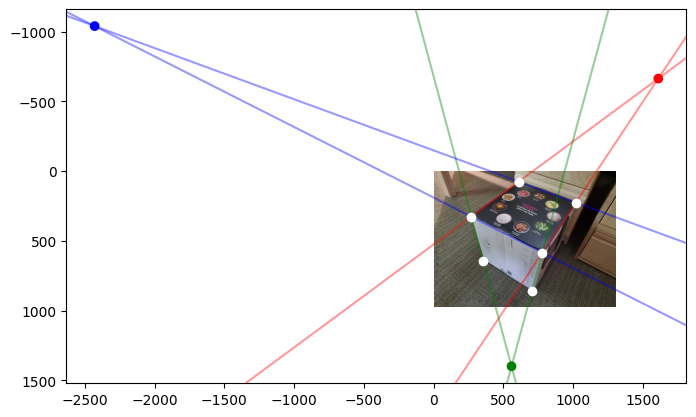

In [37]:
# Compute vanishing points
v = np.zeros((3, 2))
v[:, :2] = np.array(
    [
        intersection_from_lines(*points[v0_indices]),
        intersection_from_lines(*points[v1_indices]),
        intersection_from_lines(*points[v2_indices]),
    ]
)
assert v.shape == (3, 2)

# Display image
fig, ax = plt.subplots(figsize=(8, 10))
ax.imshow(img)

# Display annotated points
ax.scatter(points[:, 0], points[:, 1], color="white")

# Visualize vanishing points
colors = ["red", "green", "blue"]
for indices, color in zip((v0_indices, v1_indices, v2_indices), colors):
    ax.axline(*points[indices[:2]], zorder=0.1, c=color, alpha=0.4)
    ax.axline(*points[indices[2:]], zorder=0.1, c=color, alpha=0.4)
ax.scatter(v[:, 0], v[:, 1], c=colors)

### 3.2 Computing Optical Centers

Next, implement **`optical_center_from_vanishing_points()`** to compute the 2D optical center from our vanishing points. Then, run the cell below to compute a set of optical center coordinates from our vanishing points.

*Hint:* Property 3 from [1] may be useful. (Try connecting to Stanford campus network otherwise the paper link might not work for you.)
> [1] Caprile, B., Torre, V. **Using vanishing points for camera calibration.** *Int J Comput Vision 4, 127–139 (1990)*. https://doi.org/10.1007/BF00127813

In [40]:
def optical_center_from_vanishing_points(
    v0: np.ndarray, v1: np.ndarray, v2: np.ndarray
) -> np.ndarray:
    """Compute the optical center of our camera intrinsics from three vanishing
    points corresponding to mutually orthogonal directions.

    Hints:
    - Your `intersection_from_lines()` implementation might be helpful here.
    - It might be worth reviewing vector projection with dot products.

    Args:
        v0 (np.ndarray): Vanishing point in image space; shape `(2,)`.
        v1 (np.ndarray): Vanishing point in image space; shape `(2,)`.
        v2 (np.ndarray): Vanishing point in image space; shape `(2,)`.

    Returns:
        np.ndarray: Optical center; shape `(2,)`.
    """
    assert v0.shape == v1.shape == v2.shape == (2,), "Wrong shape!"

    optical_center = np.zeros(2)

    # YOUR CODE HERE
    side1 = v1 - v0 
    side2 = v2 - v1
    
    # The altitude from v2 perpendicular to side1 (v0v1)
    altitude1 = np.array([-side1[1], side1[0]])  # Perpendicular to v0v1
    line1 = np.cross(np.append(v2, 1), np.append(v2 + altitude1, 1))
    
    # The altitude from v0 perpendicular to side2 (v1v2)
    altitude2 = np.array([-side2[1], side2[0]])  # Perpendicular to v1v2
    line2 = np.cross(np.append(v0, 1), np.append(v0 + altitude2, 1))
    
    intersection = np.cross(line1, line2)
    optical_center = intersection[:2] / intersection[2]
    # END YOUR CODE

    assert optical_center.shape == (2,)
    return optical_center

Looks correct!


Text(659.5731099719243, 532.2523455153312, 'Optical center')

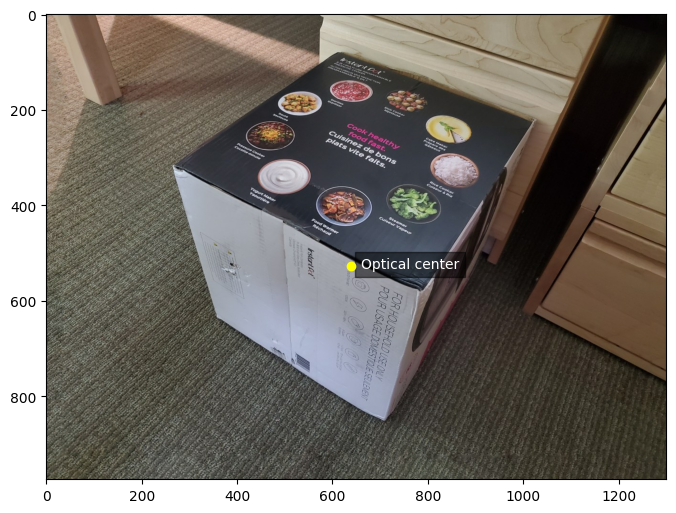

In [41]:
optical_center = optical_center_from_vanishing_points(v[0], v[1], v[2],)

assert np.allclose(np.mean(optical_center), 583.4127277436276)
assert np.allclose(np.mean(optical_center ** 2), 343524.39942528843)
print("Looks correct!")

# Display image
fig, ax = plt.subplots(figsize=(8, 10))
ax.imshow(img)

# Display optical center
ax.scatter(*optical_center, color="yellow")
ax.annotate(
    "Optical center",
    optical_center + np.array([20, 5]),
    color="white",
    backgroundcolor=(0, 0, 0, 0.5),
    zorder=0.1,
)

### 3.3 Computing Focal Lengths

Consider two vanishing points corresponding to orthogonal directions, and the constraint from above:

$$
(K^{-1}v_0)^\top(K^{-1}v_1) = 0, \text{for each } i \neq j
$$

Derive an expression for computing the focal length when the optical center is known, then implement **`focal_length_from_two_vanishing_points()`**.

When we assume square pixels and no skew, recall that the intrinsic matrix $K$ is:

$$
K = \begin{bmatrix}
    f & 0 & c_x \\
    0 & f & c_y \\
    0 & 0 & 1 \\
\end{bmatrix}
$$

*Hint:* Optional, but this problem maybe be simpler if you factorize $K$ as:

$$
K = \begin{bmatrix}
    1 & 0 & c_x \\
    0 & 1 & c_y \\
    0 & 0 & 1 \\
\end{bmatrix}\begin{bmatrix}
    f & 0 & 0 \\
    0 & f & 0 \\
    0 & 0 & 1 \\
\end{bmatrix}
$$

When working with homogeneous coordinates, note that the lefthand matrix is a simple translation.



In [42]:
def focal_length_from_two_vanishing_points(
    v0: np.ndarray, v1: np.ndarray, optical_center: np.ndarray
) -> np.ndarray:
    """Compute focal length of camera, from two vanishing points and the
    calibrated optical center.

    Args:
        v0 (np.ndarray): Vanishing point in image space; shape `(2,)`.
        v1 (np.ndarray): Vanishing point in image space; shape `(2,)`.
        optical_center (np.ndarray): Calibrated optical center; shape `(2,)`.

    Returns:
        float: Calibrated focal length.
    """
    assert v0.shape == v1.shape == optical_center.shape == (2,), "Wrong shape!"

    f = None

    # YOUR CODE HERE
    v0_shifted = v0 - optical_center
    v1_shifted = v1 - optical_center

    dot_product_xy = v0_shifted[0] * v1_shifted[0] + v0_shifted[1] * v1_shifted[1]
    f = np.sqrt(-dot_product_xy)
    # END YOUR CODE

    return float(f)

In [43]:
# If your implementation is correct, these should all be ~the same
f = focal_length_from_two_vanishing_points(v[0], v[1], optical_center)
print(f"Focal length from v0, v1: {f}")

f = focal_length_from_two_vanishing_points(v[1], v[2], optical_center)
print(f"Focal length from v1, v2: {f}")

f = focal_length_from_two_vanishing_points(v[0], v[2], optical_center)
print(f"Focal length from v0, v2: {f}")

Focal length from v0, v1: 1056.992519708474
Focal length from v1, v2: 1056.9925197084735
Focal length from v0, v2: 1056.9925197084738


### 3.4 Comparison to EXIF data

To validate our focal length computation, one smoke test we can run is compare it to parameters supplied by the camera manufacturer.

In JPEG images, these parameters and other metadata are sometimes stored using [EXIF](https://en.wikipedia.org/wiki/Exif) tags that are written when the photo is taken. Run the cell below to read & print some of this using the Python Imaging Library!

In [44]:
from PIL.ExifTags import TAGS

# Grab EXIF data
exif = {TAGS[key]: value for key, value in img._getexif().items()}

# Print subset of keys
print(f"EXIF data for {img.filename}\n=====")
for key in (
    "DateTimeOriginal",
    "FocalLength",
    "GPSInfo",
    "Make",
    "Model",
):
    print(key.ljust(25), exif[key])

EXIF data for images/pressure_cooker.jpg
=====
DateTimeOriginal          2020:11:06 01:02:20
FocalLength               4.3
GPSInfo                   {1: 'N', 2: (37.0, 25.0, 29.903), 3: 'W', 4: (122.0, 9.0, 34.294), 5: b'\x00', 6: 0.0}
Make                      samsung
Model                     SM-G970U


From above, we see that the focal length of our camera system is **`4.3mm`**.

Focal lengths are typically in millimeters, but all of the coordinates we've worked with thus far have been in pixel-space. Thus, we first need to convert our focal length from pixels to millimeters.

Try to visualize this conversion, then implement **`physical_focal_length_from_calibration()`**.

In [45]:
def physical_focal_length_from_calibration(
    f: float, sensor_diagonal_mm: float, image_diagonal_pixels: float
) -> float:
    """Compute the physical focal length of our camera, in millimeters.

    Args:
        f (float): Calibrated focal length, using pixel units.
        sensor_diagonal_mm (float): Length across the diagonal of our camera
            sensor, in millimeters.
        image_diagonal_pixels (float): Length across the diagonal of the
            calibration image, in pixels.

    Returns:
        float: Calibrated focal length, in millimeters.
    """
    f_mm = None

    # YOUR CODE HERE
    pixels_to_mm = sensor_diagonal_mm / image_diagonal_pixels
    f_mm = f * pixels_to_mm
    # END YOUR CODE

    return f_mm


In [47]:
# Length across sensor diagonal for SM-G970U (Galaxy S10e)
# > https://en.wikipedia.org/wiki/Samsung_CMOS
sensor_diagonal_mm = 7.06

# Length across image diagonal
image_diagonal_pixels = np.sqrt(img.width ** 2 + img.height ** 2)

f_mm = physical_focal_length_from_calibration(
    f, sensor_diagonal_mm, image_diagonal_pixels,
)
print(f"Computed focal length:".ljust(30), f_mm)

error = np.abs(f_mm - 4.3) / 4.3
print("Calibration vs spec error:".ljust(30), f"{error * 100:.2f}%")
assert 0.06 < error < 0.07

Computed focal length:         4.592225962548815
Calibration vs spec error:     6.80%


### 3.5 Analysis (5 points)

If everything went smoothly, your computed focal length should only deviate from the manufacturer spec by ~6.8%.

**Aside from manufacturing tolerances, name two or more other possible causes for this error, then discuss the limitations of this calibration method.**

**You answer here:**
- Our calibration method assumes a perfect pinhole camera model. Real lenses have radial and tangential distortion, especially towards the image edges. This distortion affects the position of vanishing points and therefore our focal length calculation
- Manual or algorithmic detection of vanishing points introduces measurement errors. Even small errors in identifying truly orthogonal lines in the image can propagate. The intersection points of nearly parallel lines are particularly sensitive to measurement noise


## 4 Extra Credit

You can choose to attempt both, either, or neither! This will be factored towards your final grade.

**a) Projection**

Generate a set of geometric shapes: cylinders, cubes, spheres, etc. Then, use your calibrated intrinsics to render them into the scene (i.e. overlaying them onto the image from Q3) with correct perspective.

These can be simple wireframe representations (eg `plt.plot()`); no need for fancy graphics.


**b) Extrinsic Calibration** (*Hard, possibly requires a lot of Google*)

Given that our box is 340mm (L) x 310mm (W) x 320mm (H), compute a 3D transformation (position, orientation) between the center of the box and the camera. In your submission, describe your approach and verify it by using both your calibrated extrinsics and intrinsics to overlay the image with a wireframe version of the box.

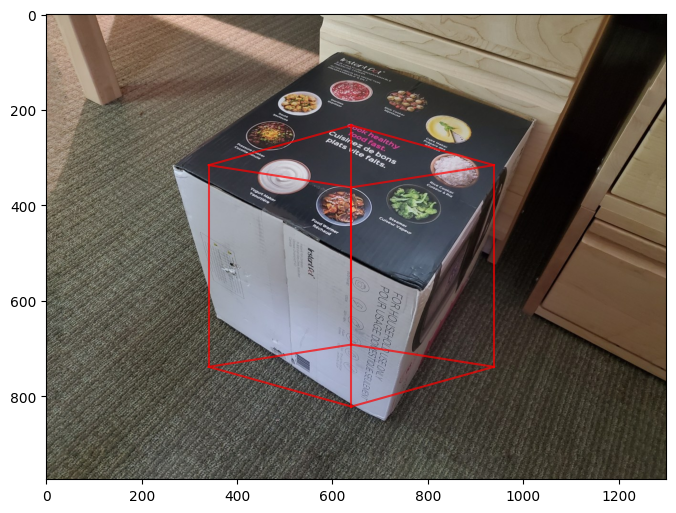

In [49]:
def create_cube(center, size):
    half = size / 2
    vertices = np.array([
        [center[0] - half, center[1] - half, center[2] - half],
        [center[0] + half, center[1] - half, center[2] - half],
        [center[0] + half, center[1] + half, center[2] - half],
        [center[0] - half, center[1] + half, center[2] - half],
        [center[0] - half, center[1] - half, center[2] + half],
        [center[0] + half, center[1] - half, center[2] + half],
        [center[0] + half, center[1] + half, center[2] + half],
        [center[0] - half, center[1] + half, center[2] + half],
    ])
    
    edges = np.array([
        [0, 1], [1, 2], [2, 3], [3, 0],  # bottom face
        [4, 5], [5, 6], [6, 7], [7, 4],  # top face
        [0, 4], [1, 5], [2, 6], [3, 7]   # connecting edges
    ])
    
    return vertices, edges

def project_points(points_3d, K, R, t):
    
    points_3d_h = np.hstack((points_3d, np.ones((points_3d.shape[0], 1))))
    extrinsic = np.hstack((R, t.reshape(-1, 1)))
    points_cam = points_3d_h @ extrinsic.T
    points_2d_h = points_cam @ K.T
    
    points_2d = points_2d_h[:, :2] / points_2d_h[:, 2:]
    
    return points_2d

def draw_wireframe(ax, vertices_2d, edges, color='r', alpha=0.5):
    for edge in edges:
        start = vertices_2d[edge[0]]
        end = vertices_2d[edge[1]]
        ax.plot([start[0], end[0]], [start[1], end[1]], color=color, alpha=alpha)

cx, cy = optical_center 
K = np.array([
    [f, 0, cx],
    [0, f, cy],
    [0, 0, 1]
])

theta = 3 * np.pi / 4 
R = np.array([
    [np.cos(theta), 0, np.sin(theta)],
    [0, 1, 0],
    [-np.sin(theta), 0, np.cos(theta)]
])
t = np.array([0, 0, -5])  # Place object in front of camera

cube_center = np.array([0, 0, 0])
cube_size = 2
vertices, edges = create_cube(cube_center, cube_size)
vertices_2d = project_points(vertices, K, R, t)

fig, ax = plt.subplots(figsize=(8, 10))
ax.imshow(img)
draw_wireframe(ax, vertices_2d, edges, color='r', alpha=0.7)
plt.show()